In [1]:
import slideflow as sf
import tensorflow as tf
import numpy as np

import seaborn as sns
from umap import UMAP
from data_util import FLAGS
from model import Model
from tqdm import tqdm

# SimCLR flags
FLAGS.train_mode = 'pretrain'
FLAGS.train_batch_size = 512
FLAGS.train_epochs = 100
FLAGS.image_size = 96
FLAGS.eval_split = 'test'
FLAGS.model_dir = '/mnt/data/tmp/simclr_cytology/',
FLAGS.use_tpu = False
FLAGS.lineareval_while_pretraining = True

In [2]:
# Load checkpoint
ckpt = '/mnt/data/tmp/simclr_cytology/ckpt-5454'
model = Model(2)
checkpoint = tf.train.Checkpoint(model=model, global_step=tf.Variable(0, dtype=tf.int64))
checkpoint.restore(ckpt).expect_partial()

In [3]:
# Load slideflow project
dts = sf.Project('/mnt/data/projects/CYTOLOGY').dataset(96, '40x')
labels = dts.labels('benign_malignant')[0]
train_dts, val_dts = dts.train_val_split(
    'categorical', 
    labels=labels, 
    val_strategy='fixed', 
    val_fraction=0.2, 
    splits='/mnt/data/projects/CYTOLOGY/simclr_splits.json',
    read_only=True
)

print("Training dataset size: ", train_dts.num_tiles)
print("Validation dataset size: ", val_dts.num_tiles)

Verifying tfrecords... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
Verifying tfrecords... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

[10:37:01] WARNING  5 slides missing tfrecords, skipping

           INFO     Using fixed validation split detected at /mnt/data/projects/CYTOLOGY/simclr_splits.json (ID: 0)

Training dataset size:  4410584
Validation dataset size:  671105


In [4]:
val_dts = val_dts.clip(500)
tf_iterator = val_dts.tensorflow(labels, FLAGS.eval_batch_size, standardize=False, infinite=False)

all_out = []
all_labels = []
all_images = []
for i, (images, batch_labels) in tqdm(enumerate(tf_iterator), total=(val_dts.num_tiles//FLAGS.eval_batch_size)):
    projection_head_outputs, supervised_head_outputs = model(tf.image.per_image_standardization(images), training=False)
    all_images.append(images)
    all_out.append(projection_head_outputs.numpy())
    all_labels.append(batch_labels.numpy())

Interleaving... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--
Interleaving... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

31it [00:03,  8.53it/s]                                                         


In [5]:
all_out = np.concatenate(all_out)
all_labels = np.concatenate(all_labels)
print(all_out.shape)
print(all_labels.shape)

(7739, 128)
(7739,)


<AxesSubplot: >

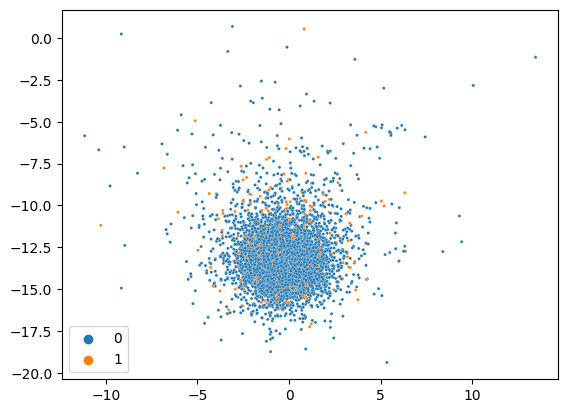

In [8]:
umap = UMAP(densmap=True)
transformed = umap.fit_transform(all_out)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=all_labels, s=5)

In [7]:
mosaic = sf.Mosaic(np.concatenate(all_images), transformed)
mosaic.plot(background="#000000")

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00